In [21]:
from dask_kubernetes.operator import KubeCluster

cluster = KubeCluster(name="daskmlcluster",
                      image='ghcr.io/dask/dask:2023.7.0-py3.10',
                      n_workers=2,
                      env={"FOO": "barr"},
                      resources={"requests": {"memory": "0.5Gi"}, "limits": {"memory": "1.5Gi"}},
                     )
cluster

Output()

KubeCluster(daskmlcluster, 'tcp://localhost:62008', workers=2, threads=24, memory=3.00 GiB)

In [23]:

from dask.distributed import Client
# Connect Dask to the cluster
client = Client(cluster)
client

<Client: 'tcp://10.244.0.28:8786' processes=2 threads=24, memory=3.00 GiB>

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
import seaborn as sns

In [55]:
df = pd.read_csv('/mnt/d/codes/Dask/Housing.csv')
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [26]:
df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


In [27]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [28]:
df.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [30]:
df.isna().any()

price               False
area                False
bedrooms            False
bathrooms           False
stories             False
mainroad            False
guestroom           False
basement            False
hotwaterheating     False
airconditioning     False
parking             False
prefarea            False
furnishingstatus    False
dtype: bool

In [31]:
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [32]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [33]:
#extracting categorical colums 
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
cat_cols

['mainroad',
 'guestroom',
 'basement',
 'hotwaterheating',
 'airconditioning',
 'prefarea',
 'furnishingstatus']

In [56]:
df_encoded = df.copy()

le = LabelEncoder()
for col in cat_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])
df_encoded.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0


In [57]:
x = df_encoded.drop(['price'], axis=1)
y = df_encoded['price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [37]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 3, 10,],
    'epsilon': [0.001, 0.01, 0.1, 0.2],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

In [58]:
svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')

In [44]:
# Fit the grid search to the data, use dask kubecluster as backend
import joblib
with joblib.parallel_backend('dask'):
    grid_search.fit(x_train, y_train)


In [45]:
pd.DataFrame(grid_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.103899,0.116554,0.022404,0.029206,0.1,0.001,linear,"{'C': 0.1, 'epsilon': 0.001, 'kernel': 'linear'}",-2.605471e+12,-2.783953e+12,-3.390616e+12,-2.497218e+12,-1.824943e+12,-2.620440e+12,5.036131e+11,13
1,0.081977,0.053567,0.008909,0.002601,0.1,0.001,poly,"{'C': 0.1, 'epsilon': 0.001, 'kernel': 'poly'}",-3.734992e+12,-3.974596e+12,-4.316278e+12,-4.249587e+12,-2.770761e+12,-3.809243e+12,5.589790e+11,37
2,0.095102,0.089959,0.037425,0.033885,0.1,0.001,rbf,"{'C': 0.1, 'epsilon': 0.001, 'kernel': 'rbf'}",-3.735080e+12,-3.974673e+12,-4.316372e+12,-4.249722e+12,-2.770838e+12,-3.809337e+12,5.589909e+11,46
3,0.157212,0.115867,0.029994,0.031925,0.1,0.001,sigmoid,"{'C': 0.1, 'epsilon': 0.001, 'kernel': 'sigmoid'}",-3.735087e+12,-3.974679e+12,-4.316380e+12,-4.249726e+12,-2.770845e+12,-3.809343e+12,5.589903e+11,51
4,0.138934,0.100767,0.048152,0.071754,0.1,0.01,linear,"{'C': 0.1, 'epsilon': 0.01, 'kernel': 'linear'}",-2.605471e+12,-2.783953e+12,-3.390616e+12,-2.497218e+12,-1.824943e+12,-2.620440e+12,5.036131e+11,14


In [46]:
# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_params

{'C': 10, 'epsilon': 0.001, 'kernel': 'linear'}

In [48]:
best_svr = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_svr.predict(x_test)

In [49]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean squared error: {mse}")
print(f"R-squared score: {r2}")

Mean squared error: 2446995789159.2197
R-squared score: 0.23089253819661604


<Axes: >

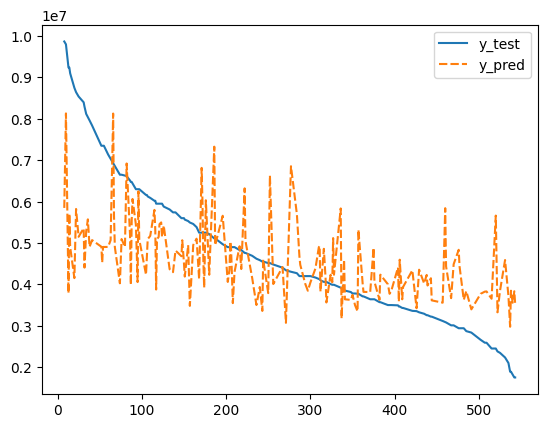

In [52]:
preds = pd.DataFrame({
    'y_test':y_test,
    'y_pred':y_pred
})
# preds['MA_pred'] = preds['y_pred'].rolling(window=100).mean()

sns.lineplot(data=preds)